In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("rocket")

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/ScholarshipAwardDecisionTool/"
scholarship_df = pd.read_excel(dataset_path + "dataset_combined.xlsx", engine='openpyxl')

scholarship_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Name,Education Qualification,Gender,Community,Religion,Exservice-men,Disability,Sports,Annual-Percentage,Income,India,Outcome
0,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,In,1
1,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,In,1
2,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,Yes,90-100,Upto 1.5L,In,1


# Exploratory Data Analysis


In [ ]:
# Basic statistics of the dataset
print(scholarship_df.describe())

             Outcome
count  245760.000000
mean        0.133333
std         0.339935
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [ ]:
# Information about the dataset
print(scholarship_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245760 entries, 0 to 245759
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Name                     245760 non-null  object
 1   Education Qualification  245760 non-null  object
 2   Gender                   245760 non-null  object
 3   Community                245760 non-null  object
 4   Religion                 245760 non-null  object
 5   Exservice-men            245760 non-null  object
 6   Disability               245760 non-null  object
 7   Sports                   245760 non-null  object
 8   Annual-Percentage        245760 non-null  object
 9   Income                   245760 non-null  object
 10  India                    245760 non-null  object
 11  Outcome                  245760 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 22.5+ MB
None


In [ ]:
# Display column names
print(scholarship_df.columns)

Index(['Name', 'Education Qualification', 'Gender', 'Community', 'Religion',
       'Exservice-men', 'Disability', 'Sports', 'Annual-Percentage', 'Income',
       'India', 'Outcome'],
      dtype='object')


In [ ]:
# Unique value counts for each column to understand distributions
for col in scholarship_df.columns:
    print(scholarship_df[col].value_counts())
    print("-" * 100)

Name
INSPIRE Scholarship 2022-23 ? Scholarship for Higher Education (SHE)                 24576
Abdul Kalam Technology Innovation National Fellowship                                24576
AAI Sports Scholarship Scheme in India 2022-23                                       24576
Glow and lovely Career Foundation Scholarship                                        24576
National Fellowship for Persons with Disabilities                                    24576
ONGC Sports Scholarship Scheme 2022-23                                               24576
Pragati Scholarship ? AICTE-Scholarship Scheme to Girl Child                         24576
Dr. Ambedkar post matric Scholarship                                                 24576
Indira Gandhi Scholarship for Single Girl Child UGC Scholarship for PG Programmes    24576
National Overseas Scholarship Scheme 2021-22                                         24576
Name: count, dtype: int64
-----------------------------------------------------------

# Helper function for analyzing feature relationships

In [ ]:
def get_graph_data(scholarship_df, feature_col):
    df_0 = scholarship_df[scholarship_df["Outcome"] == 0][[feature_col, "Outcome"]].groupby(feature_col).count().reset_index()
    df_1 = scholarship_df[scholarship_df["Outcome"] == 1][[feature_col, "Outcome"]].groupby(feature_col).count().reset_index()

    df = pd.DataFrame()
    df[feature_col] = df_0[feature_col]
    df["Outcome=0"] = df_0["Outcome"]
    df["Outcome=1"] = df_1["Outcome"]
    df["Outcome_Total"] = df["Outcome=0"] + df["Outcome=1"]
    df["Outcome=0 %"] = (df["Outcome=0"] / df["Outcome_Total"]) * 100
    df["Outcome=1 %"] = (df["Outcome=1"] / df["Outcome_Total"]) * 100

    return df

# Relationships for Key Features

# For Education Qualification

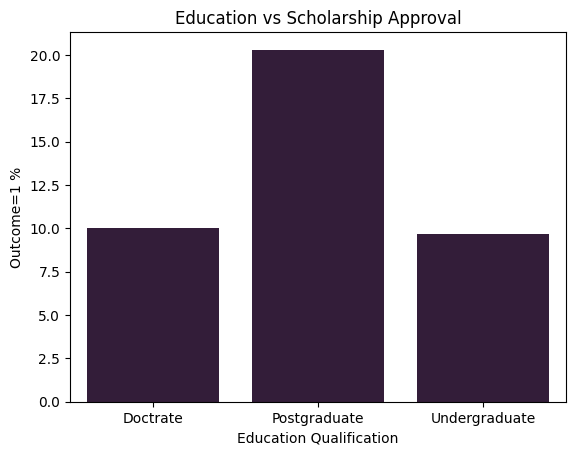

In [ ]:
# For Education Qualification
df_education = get_graph_data(scholarship_df, "Education Qualification")
sns.barplot(data=df_education, x="Education Qualification", y="Outcome=1 %").set_title("Education vs Scholarship Approval")
plt.show()

# For Gender


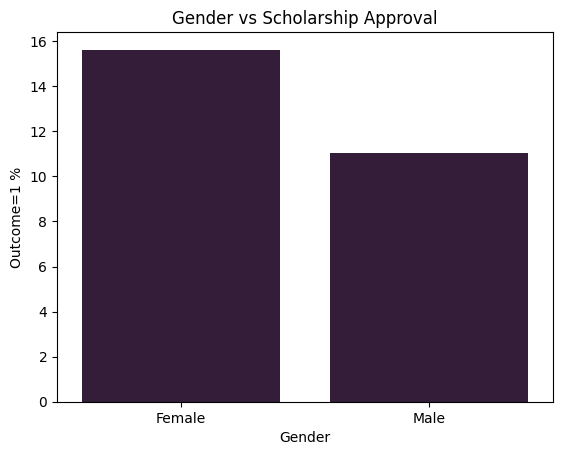

In [ ]:
df_gender = get_graph_data(scholarship_df, "Gender")
sns.barplot(data=df_gender, x="Gender", y="Outcome=1 %").set_title("Gender vs Scholarship Approval")
plt.show()

# For Income

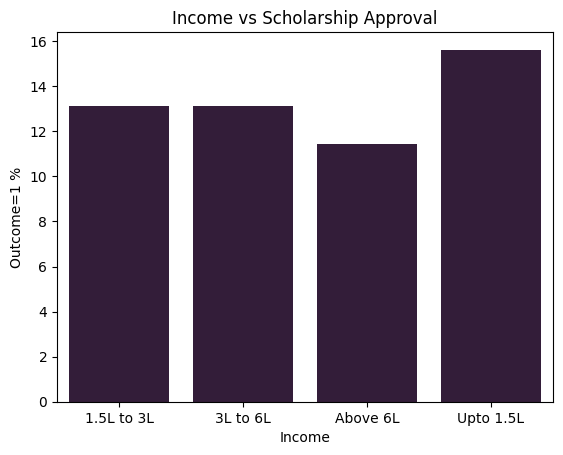

In [ ]:
df_income = get_graph_data(scholarship_df, "Income")
sns.barplot(data=df_income, x="Income", y="Outcome=1 %").set_title("Income vs Scholarship Approval")
plt.show()

# Data Cleaning and Encoding

In [ ]:
# Drop features irrelevant to the Kenyan context
scholarship_df = scholarship_df.drop(["Name", "Religion", "Exservice-men"], axis=1)

# Encode ordinal features

In [ ]:
# Encode ordinal features
def ordinal_encoding(dataframe, col_name, categories, new_col_name):
    enc = OrdinalEncoder(categories=[categories])
    categories = pd.Categorical(dataframe[col_name], categories=categories, ordered=True)
    labels, unique = pd.factorize(categories, sort=True)
    dataframe[new_col_name] = labels
    return dataframe

# Encoding Education Qualification (Undergraduate, Diploma, Postgraduate)


In [ ]:
# Encoding Education Qualification (Undergraduate, Diploma, Postgraduate)
categories = ["Undergraduate", "Diploma", "Postgraduate"]
scholarship_df = ordinal_encoding(scholarship_df, "Education Qualification", categories, "Education_Qualification")


In [ ]:
# Encoding Income levels specific to Kenya
categories = ["Below 200K", "200K-500K", "500K-1M", "Above 1M"]
scholarship_df = ordinal_encoding(scholarship_df, "Income", categories, "Income_Level")


In [ ]:
# Encode categorical (nominal) features
def nominal_encoding(dataframe, col_name):
    return pd.get_dummies(dataframe, columns=[col_name])

In [ ]:
# Encode categorical (nominal) features
def nominal_encoding(dataframe, col_name):
    return pd.get_dummies(dataframe, columns=[col_name])

scholarship_df = nominal_encoding(scholarship_df, "Gender")
scholarship_df = nominal_encoding(scholarship_df, "Disability")
scholarship_df = nominal_encoding(scholarship_df, "Sports")

In [ ]:
# Drop original columns after encoding
scholarship_df = scholarship_df.drop(["Education Qualification", "Income"], axis=1)
scholarship_df

,Name,Community,Religion,Exservice-men,Annual-Percentage,India,Outcome,Education_Qualification,Income_Level,Gender_Female,Gender_Male,Disability_No,Disability_Yes,Sports_No,Sports_Yes
0,INSPIRE Scholarship 2022-23 ? Scholarship for ...,General,Hindu,Yes,90-100,In,1,0,-1,False,True,False,True,False,True
1,INSPIRE Scholarship 2022-23 ? Scholarship for ...,General,Hindu,Yes,90-100,In,1,0,-1,False,True,False,True,True,False
2,INSPIRE Scholarship 2022-23 ? Scholarship for ...,General,Muslim,Yes,90-100,In,1,0,-1,False,True,False,True,False,True
3,INSPIRE Scholarship 2022-23 ? Scholarship for ...,General,Muslim,Yes,90-100,In,1,0,-1,False,True,False,True,True,False
4,INSPIRE Scholarship 2022-23 ? Scholarship for ...,General,Chirstian,Yes,90-100,In,1,0,-1,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245755,National Overseas Scholarship Scheme 2021-22,Minority,Muslim,No,60-70,Out,1,-1,-1,True,False,True,False,True,False
245756,National Overseas Scholarship Scheme 2021-22,Minority,Chirstian,No,60-70,Out,1,-1,-1,True,False,True,False,False,True
245757,National Overseas Scholarship Scheme 2021-22,Minority,Chirstian,No,60-70,Out,1,-1,-1,True,False,True,False,True,False
245758,National Overseas Scholarship Scheme 2021-22,Minority,Others,No,60-70,Out,1,-1,-1,True,False,True,False,False,True


# Data Splitting and Scaling

In [ ]:

# Separate features (X) and target variable (y)
y = scholarship_df["Outcome"]
X = scholarship_df.drop("Outcome", axis=1)
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(non_numeric_columns, axis=1)

In [ ]:


# Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8554 - loss: 0.4123 - val_accuracy: 0.8665 - val_loss: 0.3744
Epoch 2/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8661 - loss: 0.3815 - val_accuracy: 0.8665 - val_loss: 0.3733
Epoch 3/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8670 - loss: 0.3771 - val_accuracy: 0.8665 - val_loss: 0.3730
Epoch 4/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8667 - loss: 0.3757 - val_accuracy: 0.8665 - val_loss: 0.3721
Epoch 5/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8658 - loss: 0.3769 - val_accuracy: 0.8665 - val_loss: 0.3708
Epoch 6/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8660 - loss: 0.3767 - val_accuracy: 0.8665 - val_loss: 0.3720
Epoch 7/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8669 - loss: 0.3745 - val_accuracy: 0.8665 - val_loss: 0.3701
Epoch 8/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8663 - loss: 0

In [ ]:
# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Test Loss: 0.3707220256328583, Test Accuracy: 0.8669026494026184


In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).flatten()

1536/1536 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


# Performance Metrics

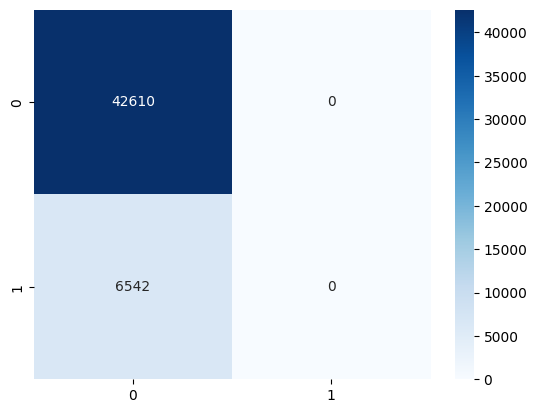

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     42610
           1       0.00      0.00      0.00      6542

    accuracy                           0.87     49152
   macro avg       0.43      0.50      0.46     49152
weighted avg       0.75      0.87      0.81     49152



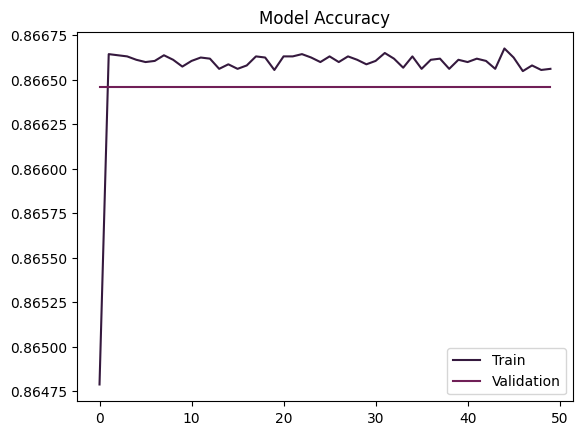

In [ ]:
# Accuracy and Loss over epochs
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Model Accuracy')
plt.show()

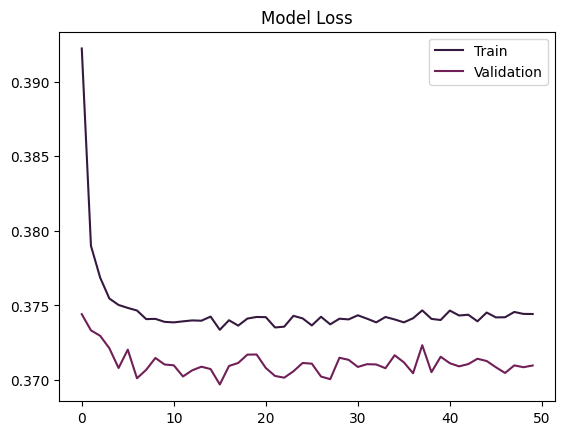

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Save the model
model.save("kenya_scholarship_model.h5")